# Computer Hardware

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from MachineLearningUtils.preprocessing_data import PreProcessingData
from MachineLearningUtils.svm_learning import SVMLearning
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, binarize, RobustScaler, MinMaxScaler
from MachineLearningUtils.linear_learning import LinearRegressionLearning
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
columns = ['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df = pd.read_csv('du lieu cung cap/machine.data.txt', header=None, names=columns)

In [4]:
df.head()

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [5]:
df.shape

(209, 10)

## Preprocessing data

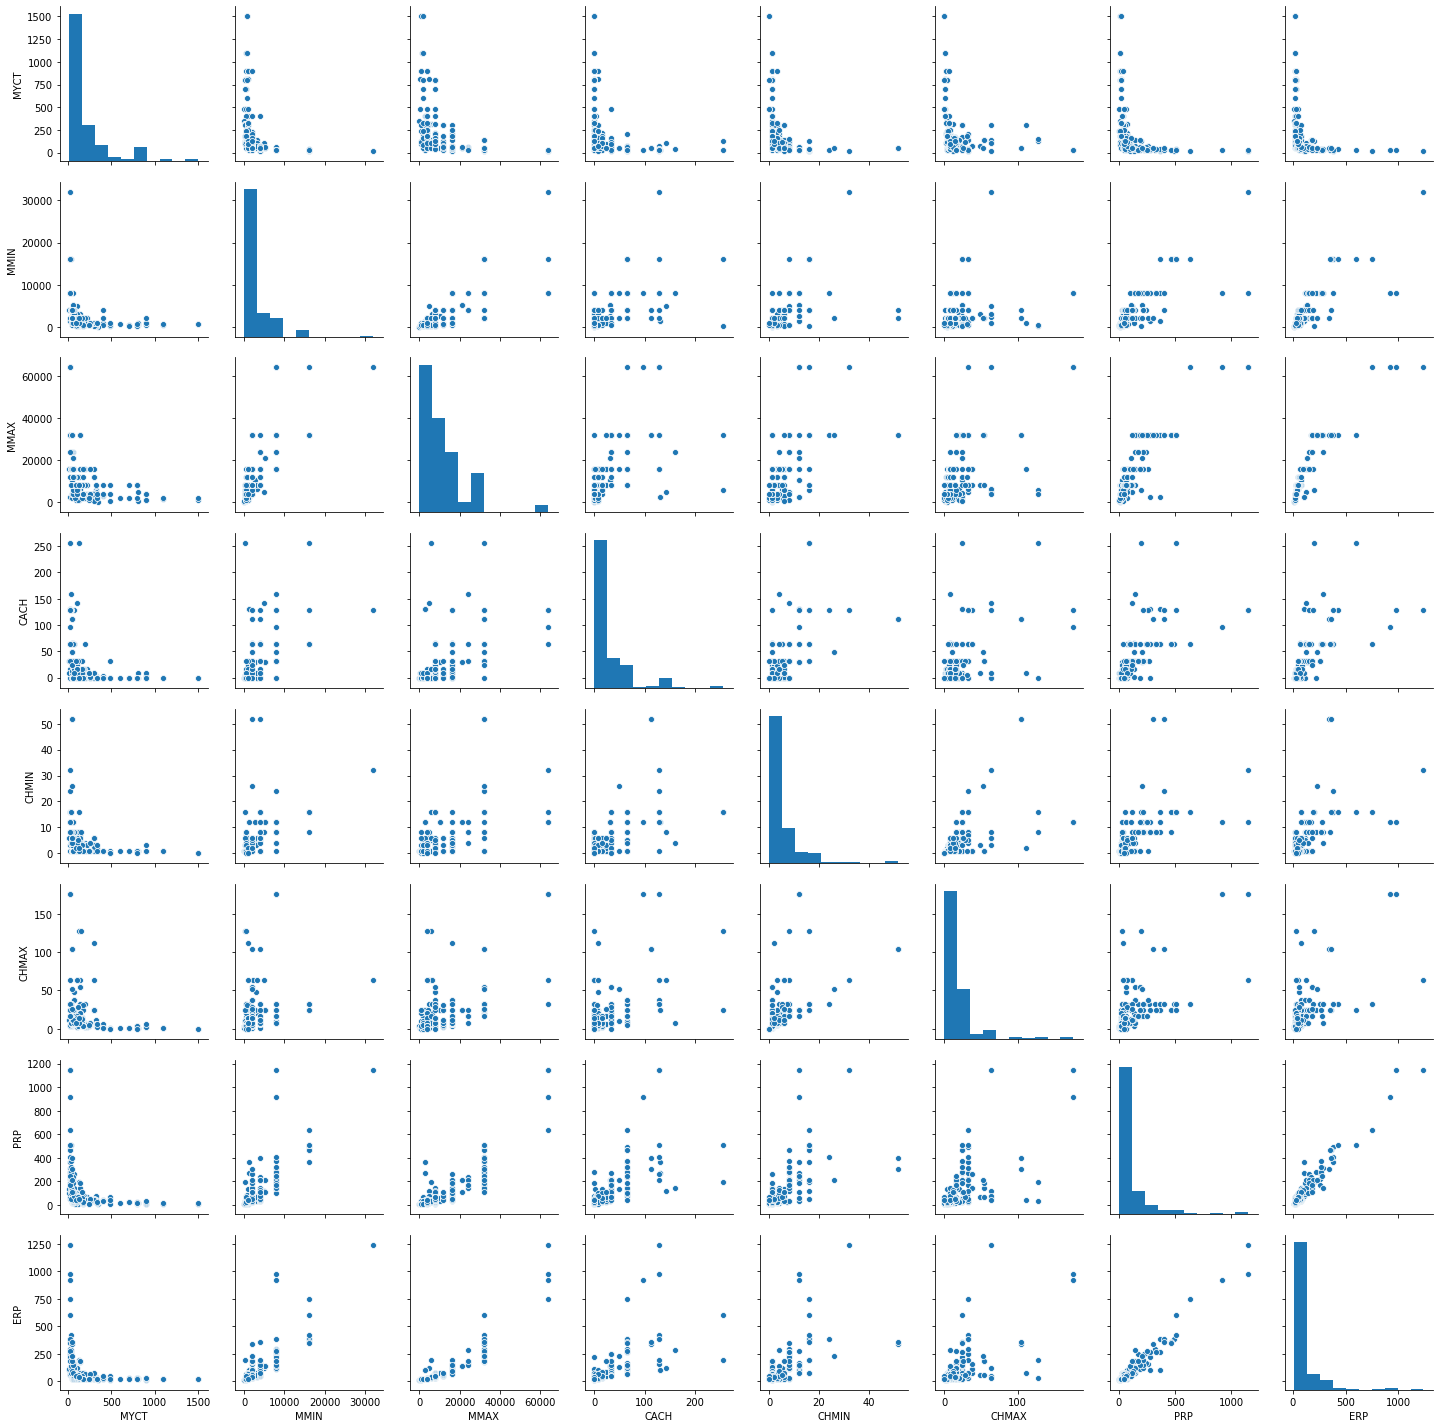

In [6]:
sns.pairplot(df)

In [7]:
output_col = 60
ppd = PreProcessingData(df, 'classification')
print('Total null columns = ', ppd.get_null_column().shape[0])

Total null columns =  0


1. Các feature có chứ dữ liệu liên tục và dữ liệu category
2. Dữ liệu dự đoán liên tục
3. Các features có chứa outlier
4. Dựa trên đồ thị pair plot, phần lớn các features gần như tuyến tính với với nhau
5. Các feature trong data bị lệch trái
6. Feature 1 là model name là uique trong dữ liệu ==> bỏ feature 2
7. Dữ liệu của các cột có thể cần scale do dữ liệu 
8. Dữ liệu không bị missing data

==> Có thể chọn thuật toán LinearRegression

# Tiền xử lý dữ liệu

In [8]:
df.drop(['model_name'], axis=1, inplace=True)

In [9]:
ppd = PreProcessingData(df, 'regression')

In [10]:
output_col = 'ERP'

In [11]:
le = ppd.label_encode('vendor_name')
inputs = ppd.data.drop([output_col], axis=1)
output = ppd.data[output_col]

In [12]:
ppd.get_k_best_features_by_random_forest(output_col, 10)

PRP            0.551375
MMAX           0.337546
MMIN           0.068145
CACH           0.017047
MYCT           0.008528
CHMIN          0.008064
CHMAX          0.007351
vendor_name    0.001944
dtype: float64

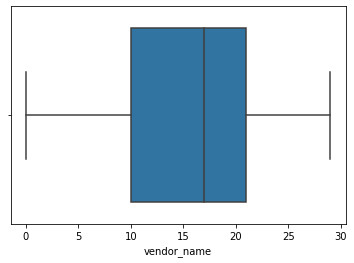

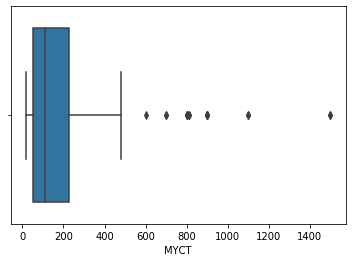

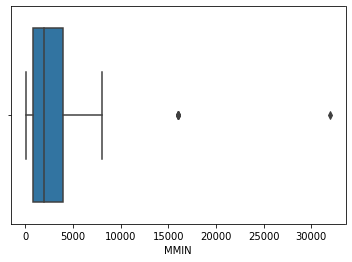

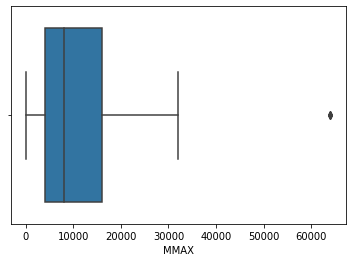

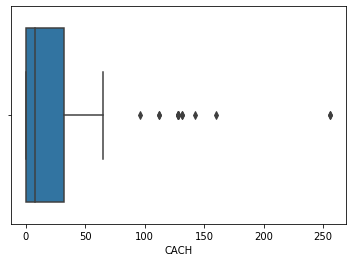

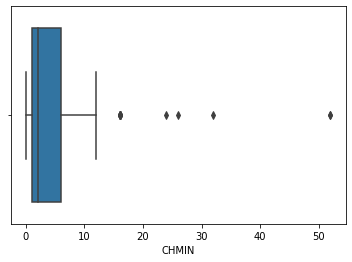

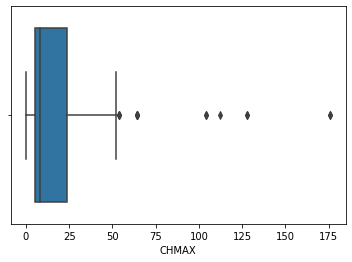

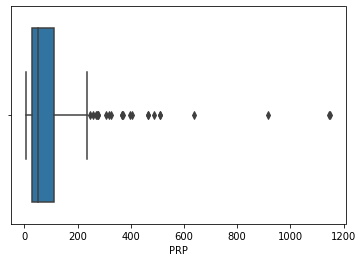

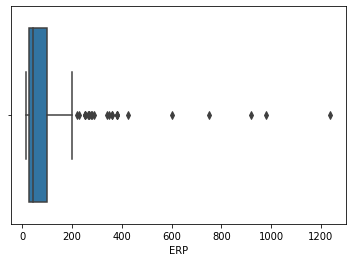

In [13]:
ppd.draw_plot(sns.boxplot)

## Chọn thuật toán thích hợp để build model

## Áp dụng dữ liệu gốc

In [14]:
ppd.get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LinearRegression,0.900342
1,KNeighborsRegressor,0.607927
2,DecisionTreeRegressor,0.878942
3,RandomForestRegressor,0.727013
4,SVR,-0.095252


Từ kết quả của kiểm tra các model ==> chọn SVC algorithms

## Áp dụng dữ liệu sau khi scale

In [15]:
rbs = RobustScaler()
rbs.fit(df)
tmp = rbs.transform(df)
tmp_df = pd.DataFrame(data=tmp, columns=df.columns)
tmp_df.head()

,vendor_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,-1.545455,0.085714,-0.539604,-0.166667,7.75,2.8,6.315789,1.720930,2.109589
1,-1.454545,-0.462857,1.856436,2.000000,0.75,1.2,1.263158,2.546512,2.849315
2,-1.454545,-0.462857,1.856436,2.000000,0.75,1.2,1.263158,1.976744,2.849315
3,-1.454545,-0.462857,1.856436,2.000000,0.75,1.2,1.263158,1.418605,2.849315
4,-1.454545,-0.462857,1.856436,0.666667,0.75,1.2,0.421053,0.953488,1.191781


In [16]:
PreProcessingData(tmp_df, 'regression').get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LinearRegression,0.900342
1,KNeighborsRegressor,0.643749
2,DecisionTreeRegressor,0.877918
3,RandomForestRegressor,0.796381
4,SVR,0.328018


Từ dữ kết quả chạy thuật toán => chọn LinearRegression để build model

### 1. Tạo X_train, X_test, y_train, y_test từ dữ liệu đã đọc và chuẩn hóa,với tỷ lệ dữ liệu test là 0.3

In [36]:
X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.3, random_state=42)

### 2. Chọn thuật toán xây dựng model

1. Do dữ liệu dự đoán là category nên chọn các thuật toán classifi
2. Từ dữ kết quả chạy model qua các thuật toán liên quan => chọn SVC
3. Sử dụng grid search => ta chọn được best params C=10, gamma=1, kernel=rbf

In [ ]:
# from sklearn.svm import SVC

# connectsionist_model = SVC(
#     C= 10,
#     gamma= 1,
#     kernel= 'rbf',
#     probability= True,
#     random_state= 42)
# connectsionist_model.fit(X_train, y_train)

In [37]:
linear_regression_learning = LinearRegressionLearning(input_data=inputs, output_data=output, mode='reegession')
linear_regression_learning.train_test_split(test_size=0.3)
linear_regression_learning.build_model()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

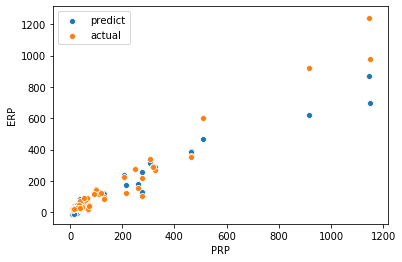

In [32]:
# fig, ax = plt.subplots()

sns.scatterplot(linear_regression_learning.X_test.PRP, linear_regression_learning.y_pred, label='predict')
sns.scatterplot(linear_regression_learning.X_test.PRP, linear_regression_learning.y_test, label='actual')

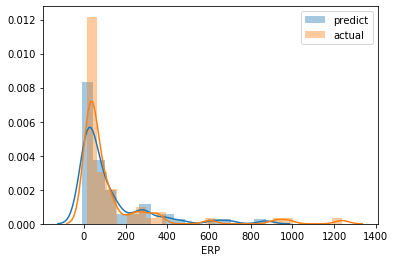

In [35]:
sns.distplot(linear_regression_learning.y_pred, label='predict')
sns.distplot(linear_regression_learning.y_test, label='actual')
plt.legend()

### 3. Đánh giá model

In [ ]:
y_pred = connectsionist_model.predict(X_test)

In [ ]:
print('Độ chính xác trên tập Train: ', connectsionist_model.score(X_train, y_train)*100, '%')
print('Độ chính xác trên tập Test: ', connectsionist_model.score(X_test, y_test)*100, '%')
print('Độ chính xác trên toàn dữ liệu: ', connectsionist_model.score(inputs, output)*100, '%')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print(confusion_matrix(y_test, y_pred))

**Summary about the model:**
1. High precision: ~0.92, High recall: ~0.92
3. High training R^2 score: 1 and High testing score: ~92

=> The good model

### 4. Trực quan hóa kết quả dự đoán được từ model

In [ ]:
# chọn column để trực quan hóa dữ liệu
ppd.get_k_best_features_by_extra_tree(output_col, 3)

In [ ]:
svc_rbf_learning.plot_scatter(8, 20)
svc_rbf_learning.plot_scatter(8, 20, 36)

1. Dữ liệu dự đoán trộn lẫn vào nhau khó phân biệt rõ ràng nếu số chiều dữ liệu nhỏ
2. Có một số điểm tách biệt với nhóm còn lại

### 5. Dựa trên kết quả, hãy cho biết nếu trong thành phần của món ăn có “cumin” và “fish” nhưng không có “yogurt” thì món ăn đó thường là món ăn của nước nào?

In [ ]:
X_new = [[0.0123,0.0309,0.0169,0.0313,0.0358,0.0102,0.0182,0.0579,0.1122,0.0835,0.0548,0.0847,0.2026,0.2557,0.1870,0.2032,0.1463,0.2849,0.5824,0.7728,0.7852,0.8515,0.5312,0.3653,0.5973,0.8275,1.0000,0.8673,0.6301,0.4591,0.3940,0.2576,0.2817,0.2641,0.2757,0.2698,0.3994,0.4576,0.3940,0.2522,0.1782,0.1354,0.0516,0.0337,0.0894,0.0861,0.0872,0.0445,0.0134,0.0217,0.0188,0.0133,0.0265,0.0224,0.0074,0.0118,0.0026,0.0092,0.0009,0.0044],        [0.0203,0.0121,0.0380,0.0128,0.0537,0.0874,0.1021,0.0852,0.1136,0.1747,0.2198,0.2721,0.2105,0.1727,0.2040,0.1786,0.1318,0.2260,0.2358,0.3107,0.3906,0.3631,0.4809,0.6531,0.7812,0.8395,0.9180,0.9769,0.8937,0.7022,0.6500,0.5069,0.3903,0.3009,0.1565,0.0985,0.2200,0.2243,0.2736,0.2152,0.2438,0.3154,0.2112,0.0991,0.0594,0.1940,0.1937,0.1082,0.0336,0.0177,0.0209,0.0134,0.0094,0.0047,0.0045,0.0042,0.0028,0.0036,0.0013,0.0016]]

In [ ]:
X_new_predict = le.inverse_transform(connectsionist_model.predict(X_new))

In [ ]:
print('Dự đoán dựa trên dữ liệu 1:', X_new_predict[0])
print('Dự đoán dựa trên dữ liệu 2:', X_new_predict[1])